In [3]:
#Ungraded Lab: Build a Multi-output Model
#In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the UCI Machine Learning Repository. It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
#Utilities
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()


In [5]:
#Prepare the Data

# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)


In [6]:
#Build the Model
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

In [7]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

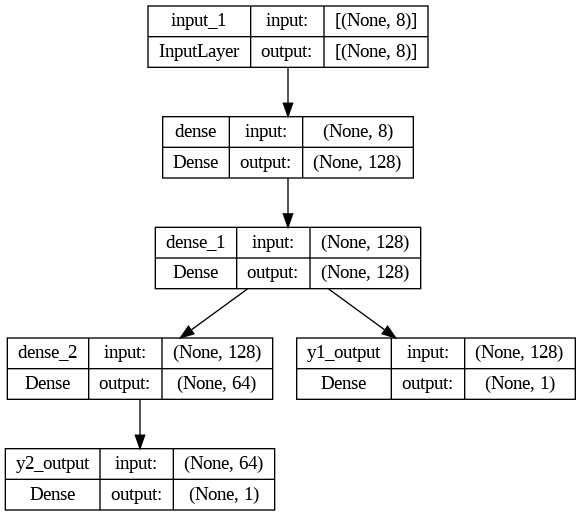

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
#Configure parameters
from sklearn.metrics import mean_absolute_error
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001)
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
model.compile(optimizer=opt,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [ ]:
assert not np.any(np.isnan(norm_train_X))

In [ ]:
## Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 2s 7ms/step - loss: 0.6807 - y1_output_loss: 0.3039 - y2_output_loss: 0.3768 - y1_output_root_mean_squared_error: 0.5513 - y2_output_root_mean_squared_error: 0.6138 - val_loss: 0.9477 - val_y1_output_loss: 0.3744 - val_y2_output_loss: 0.5733 - val_y1_output_root_mean_squared_error: 0.6119 - val_y2_output_root_mean_squared_error: 0.7572
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 0.5605 - y1_output_loss: 0.2356 - y2_output_loss: 0.3249 - y1_output_root_mean_squared_error: 0.4854 - y2_output_root_mean_squared_error: 0.5700 - val_loss: 0.5510 - val_y1_output_loss: 0.1851 - val_y2_output_loss: 0.3659 - val_y1_output_root_mean_squared_error: 0.4303 - val_y2_output_root_mean_squared_error: 0.6049
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 0.4368 - y1_output_loss: 0.1803 - y2_output_loss: 0.2565 - y1_output_root_mean_squared_error: 0.4246 - y2_output_root_mean_squared_error: 0.5064 

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))


5/5 [==============================] - 0s 3ms/step - loss: 1.1628 - y1_output_loss: 0.5718 - y2_output_loss: 0.5910 - y1_output_root_mean_squared_error: 0.7562 - y2_output_root_mean_squared_error: 0.7688
Loss = 1.1627870798110962, Y1_loss = 0.571806788444519, Y1_mse = 0.7561790943145752, Y2_loss = 0.5909803509712219, Y2_mse = 0.7687524557113647


5/5 [==============================] - 0s 2ms/step


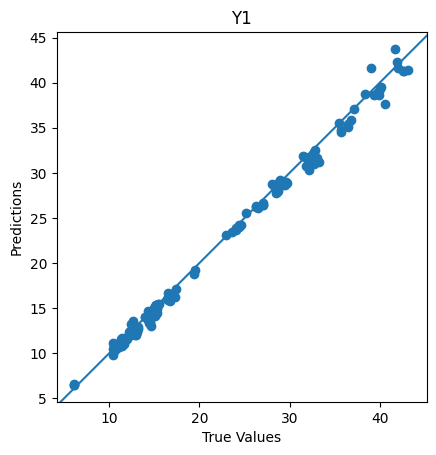

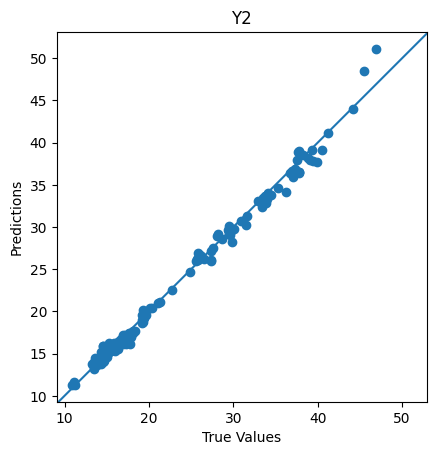

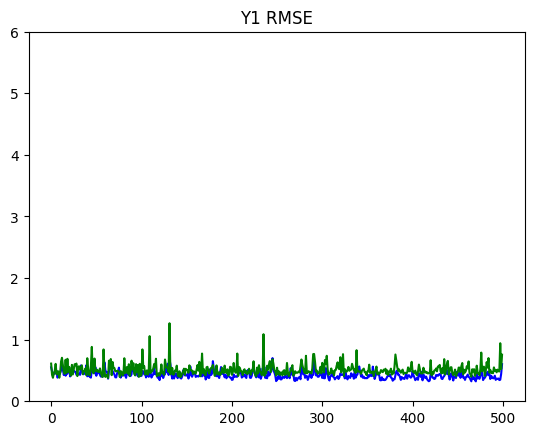

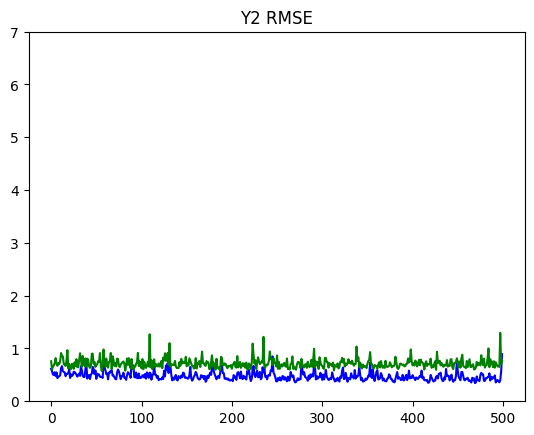

In [ ]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)